## 7.3 Optimal Monetary Policy with Zero Lower Bound

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from decimal import *
import time

### 7.3.2 Numerical Solution of Discretionary Policy with Time Iteration

#### Source code

See the source code provided by the author ([TomoakiYamada](https://github.com/TomoakiYamada)) [here](https://github.com/quant-macro-book/chapter7/blob/master/Python/7_3_2_NstateNK/discNK.ipynb).

#### Model ([Adam and Billi, 2007](https://www.sciencedirect.com/science/article/pii/S0304393206001991))

<img src="./figure/model_Adam and Billi (2007).png" width="700">

#### Calibrating the model

We calibrate the model following [Adam and Billi (2007)](https://www.sciencedirect.com/science/article/pii/S0304393206001991). The calibration is as follows:

<img src="./figure/table 1_Adam and Billi (2007).png" width="700">


In [ ]:
class MonetaryPolicy:
    def __init__(self, rstar, beta, sigma, alpha, theta, omega, kappa, lamd, rho_u, rho_g, sigma_u, sigma_g, N_u, N_g, maxiter, tol):
        self.rstar = rstar       # stationary value of the natural rate of interest
        self.beta = beta         # discount factor
        self.sigma = sigma       # real rate elasticity of output
        self.alpha = alpha       # share of firms keeping price fixed
        self.theta = theta       # price elasticity of demand
        self.omega = omega       # elasticity of firms' marginal costs
        self.kappa = kappa       # slope of the Phillips curve
        self.lamd = lamd         # weight on output in the loss function
        self.rho_u = rho_u       # AR-coefficient mark-up shocks
        self.rho_g = rho_g       # AR-coefficient real rate shocks
        self.sigma_u = sigma_u   # Std mark-up shock innovations
        self.sigma_g = sigma_g   # Std real rate shock innovations
        self.N_u = N_u           # Number of mark-up shocks
        self.N_g = N_g           # Number of real rate shocks
        self.maxiter = maxiter   # Maximum number of iterations
        self.tol = tol           # Tolerance for stopping criterion

    def discretionary_policy(self):
        # STEP 1(a)-1: generate the grid for the state variables
        self.g_grid, self.P_g = self._tauchen_method(self.N_g, self.sigma*self.rstar, self.rho_g, self.sigma_g)
        self.u_grid, self.P_u = self._tauchen_method(self.N_u, 0.0, self.rho_u, self.sigma_u)
        # STEP 1(a)-2: define the state space of Markov chain
        self.num_states = self.N_g * self.N_u
        self.states = np.empty((self.num_states, 2))
        for i in range(self.N_g):
            for j in range(self.N_u):
                self.states[i * self.N_u + j, 0] = self.g_grid[i]
                self.states[i * self.N_u + j, 1] = self.u_grid[j]
        # STEP 1(a)-3: compute the transition matrix of Markov chain
        self.P = np.kron(self.P_g, self.P_u)
        # STEP 1(b): initialize the policy function
        y_old, pi_old, r_old = self._initialize_policy_functions()
        y_new, pi_new, r_new = self._initialize_policy_functions()
        # STEP 2: time iteration
        for _ in range(self.maxiter):
            for state in range(self.num_states):
                g = self.states[state, 0]       # current state of the real rate shock (g)
                u = self.states[state, 1]       # current state of the mark-up shock (u)
                # compute the expected value of GDP gap and inflation rate
                y_e = self.P[state, :] @ y_old
                pi_e = self.P[state, :] @ pi_old
                # solve the system of equations
                y_tmp, pi_tmp, r_tmp = self._solve_discretionary_equilibrium(g, u, y_e, pi_e)
                # update the policy functions
                y_new[state] = y_tmp
                pi_new[state] = pi_tmp
                r_new[state] = r_tmp
            # compute the distance between the old and new policy functions
            dist = self._distance_of_policy_functions(y_new, pi_new, r_new, y_old, pi_old, r_old)
            # check the convergence
            if dist < self.tol:
                break
            else:
                y_old = y_new.copy()
                pi_old = pi_new.copy()
                r_old = r_new.copy()
        return y_new, pi_new, r_new

    def _tauchen_method(self, N, mu, rho, sigma, m=3):
        """
        This function discretizes a first-order Markov process around the mean
        using Tauchen's method.

        z'=(1-ρ)μ + ρ*z + ε, ε~N(0,σ_{ε}^2)

        inputs:
        - N: number of grid points
        - mu: mean of the process
        - rho: persistence of AR(1) process
        - sigma: standard deviation of the process
        - m: scale parameter for the grid

        outputs:
        - z: grid points
        - P: transition matrix
        """
        # Compute the steady state standard deviation
        sigma_z = np.sqrt( sigma**2 / (1-rho**2) )
        const = (1 - rho) * mu
        # Compute the bounds of the grid
        z_max = m * sigma_z
        z_min = -z_max
        # Create the grid
        z = np.linspace(z_min, z_max, N)
        z += mu                             # Shift the grid to the mean (E[z] = mu)
        # Compute the step size
        step = (z_max - z_min) / (N - 1)
        # Create the transition matrix
        P = np.empty((N, N))
        for i in range(N):
            for j in range(N):
                if j == 0:
                    P[i, j] = self._cdf_normal((z[0] - const - rho * z[i] + step / 2) / sigma)
                elif j == N - 1:
                    P[i, j] = 1 - self._cdf_normal((z[N - 1] - const - rho * z[i] - step / 2) / sigma)
                else:
                    P[i, j] = self._cdf_normal((z[j] - const - rho * z[i] + step / 2) / sigma) - self._cdf_normal((z[j] - const - rho * z[i] - step / 2) / sigma)
        return z, P

    def _cdf_normal(self, x):
        """
        This function computes the CDF of a normal distribution.
        """
        return stats.norm.cdf(x, loc=0, scale=1)

    def _initialize_policy_functions(self):
        """
        This function initializes the policy functions.
        """
        return np.zeros(self.num_states), np.zeros(self.num_states), np.zeros(self.num_states)

    def _solve_discretionary_equilibrium(self, g, u, y_e, pi_e):
        # solve the system of equations
        pi_tmp = (self.beta * pi_e + u) / (1 + (self.kappa**2 / self.lamd))
        y_tmp = -(self.kappa / self.lamd) * pi_tmp
        # r_tmp = - y_tmp + y_e + pi_e + g
        r_tmp = (-y_tmp + y_e + g) / self.sigma + pi_e
        # check if r_tmp is non-positive
        if r_tmp <= 0:
            r_tmp = 0
            y_tmp = y_e - self.sigma * (r_tmp - pi_e) + g
            # y_tmp = y_e + pi_e + g
            pi_tmp = self.kappa * y_tmp + self.beta * pi_e + u
        return y_tmp, pi_tmp, r_tmp

    def _distance_of_policy_functions(self, y_new, pi_new, r_new, y_old, pi_old, r_old):
        """
        This function computes the distance between the old and new policy functions.
        """
        dist_y = np.max(np.abs(y_new - y_old))
        dist_pi = np.max(np.abs(pi_new - pi_old))
        dist_r = np.max(np.abs(r_new - r_old))
        return max(dist_y, dist_pi, dist_r)

In [3]:
# instantiate the model
model = MonetaryPolicy(     rstar = 3.5 / 4,
                            beta = 1 / (1 + (3.5 / 4) / 100),
                            sigma = 6.25,
                            alpha = 0.66,
                            theta = 7.66,
                            omega = 0.47,
                            kappa = 0.024,
                            lamd = 0.003,
                            rho_u = 0.0,
                            rho_g = 0.8,
                            sigma_u =0.154,
                            sigma_g = 1.524,
                            N_u = 31,
                            N_g = 31,
                            maxiter = 2000,
                            tol = 1e-5
                        )

In [4]:
# solve the model with time iteration method in the discretionary policy
start = time.time()
y, pi, r = model.discretionary_policy()
end = time.time()
print(f"Elapsed time: {end-start:.6f} seconds")

Elapsed time: 0.263949 seconds


In [5]:
# show all the grids the model has
g_grid = model.g_grid
u_grid = model.u_grid
print(f"Grids of the real rate shock (g):\n {g_grid}")
print(f"Grids of the mark-up shock (u):\n {u_grid}")

Grids of the real rate shock (g):
 [-2.15125 -1.64325 -1.13525 -0.62725 -0.11925  0.38875  0.89675  1.40475
  1.91275  2.42075  2.92875  3.43675  3.94475  4.45275  4.96075  5.46875
  5.97675  6.48475  6.99275  7.50075  8.00875  8.51675  9.02475  9.53275
 10.04075 10.54875 11.05675 11.56475 12.07275 12.58075 13.08875]
Grids of the mark-up shock (u):
 [-0.462  -0.4312 -0.4004 -0.3696 -0.3388 -0.308  -0.2772 -0.2464 -0.2156
 -0.1848 -0.154  -0.1232 -0.0924 -0.0616 -0.0308  0.      0.0308  0.0616
  0.0924  0.1232  0.154   0.1848  0.2156  0.2464  0.2772  0.308   0.3388
  0.3696  0.4004  0.4312  0.462 ]


shape of the states: (961, 2)
states:
 [[-2.15125 -0.462  ]
 [-2.15125 -0.4312 ]
 [-2.15125 -0.4004 ]
 ...
 [13.08875  0.4004 ]
 [13.08875  0.4312 ]
 [13.08875  0.462  ]]


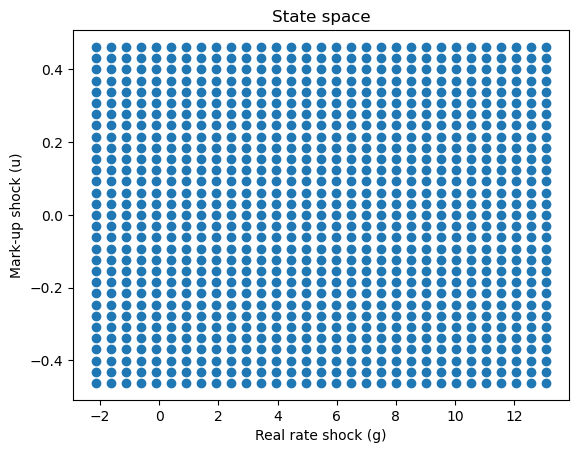

In [6]:
# show all the states the model has
print(f"shape of the states: {model.states.shape}")
print(f"states:\n {model.states}")

# plot the state space
plt.scatter(model.states[:, 0], model.states[:, 1])
plt.xlabel("Real rate shock (g)")
plt.ylabel("Mark-up shock (u)")
plt.title("State space")
plt.show()

In [7]:
# transiton matrix
print(f"shape of the transition matrix of g: {model.P_g.shape}")
print(f"shape of the transition matrix of u: {model.P_u.shape}")
print(f"shape of the transition matrix of states: {model.P.shape}")

shape of the transition matrix of g: (31, 31)
shape of the transition matrix of u: (31, 31)
shape of the transition matrix of states: (961, 961)


In [8]:
# convert the policy functions to a matrix
y_mat = np.empty((model.N_g, model.N_u))
p_mat = np.empty_like(y_mat)
r_mat = np.empty_like(y_mat)

for ig in range(model.N_g):
    for iu in range(model.N_u):

        y_mat[ig,iu] = y[model.N_u * ig + iu]
        p_mat[ig,iu] = pi[model.N_u * ig + iu]
        r_mat[ig,iu] = r[model.N_u * ig + iu]

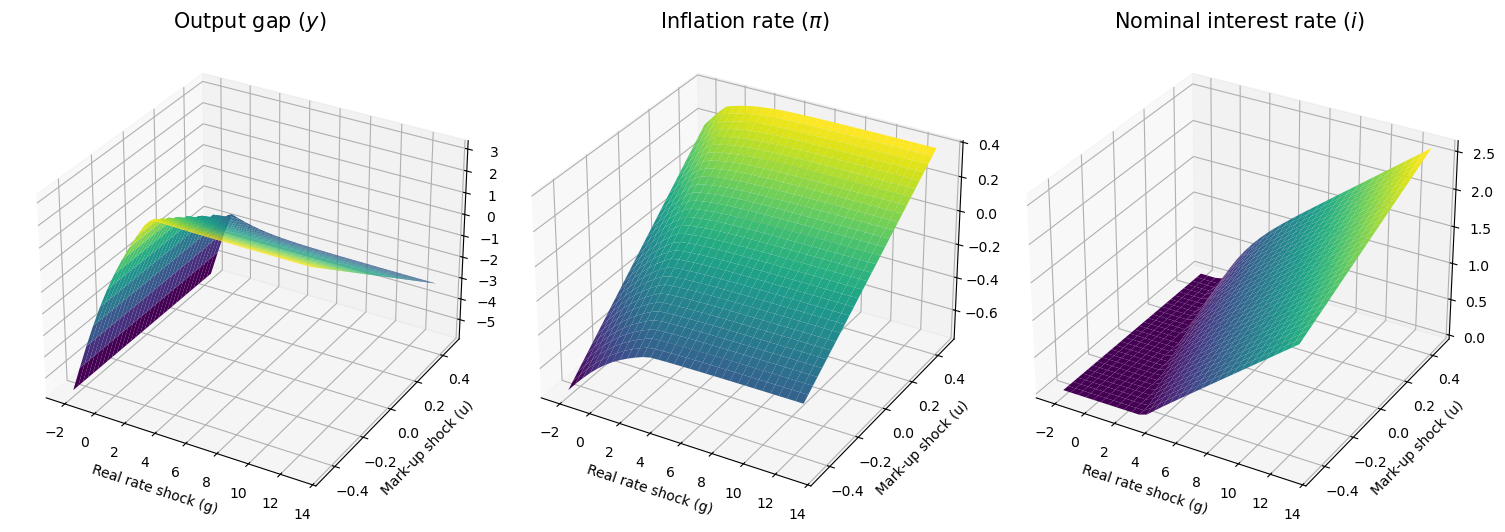

In [9]:
# 3D plot of the policy functions
G, U = np.meshgrid(g_grid, u_grid, indexing="ij")
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), subplot_kw={"projection": "3d"})
titles = [r"Output gap ($y$)", r"Inflation rate ($\pi$)", r"Nominal interest rate ($i$)"]
for i, ax in enumerate(axis):
    if i == 0:
        z = y_mat
    elif i == 1:
        z = p_mat
    else:
        z = r_mat
    ax.plot_surface(G, U, z, cmap="viridis")
    ax.set_title(titles[i], fontsize=15)
    ax.set_xlabel("Real rate shock (g)")
    ax.set_ylabel("Mark-up shock (u)")
plt.tight_layout()
plt.show()

In [10]:
# replicate Fig 4 and 5 in the original paper
g_zero_idx = np.where((-0.2 < g_grid) & (g_grid < 0.1))[0][0]
u_zero_idx = np.where(u_grid == 0)[0][0]
g_grid[g_zero_idx], u_grid[u_zero_idx]

(np.float64(-0.11925000000000097), np.float64(0.0))

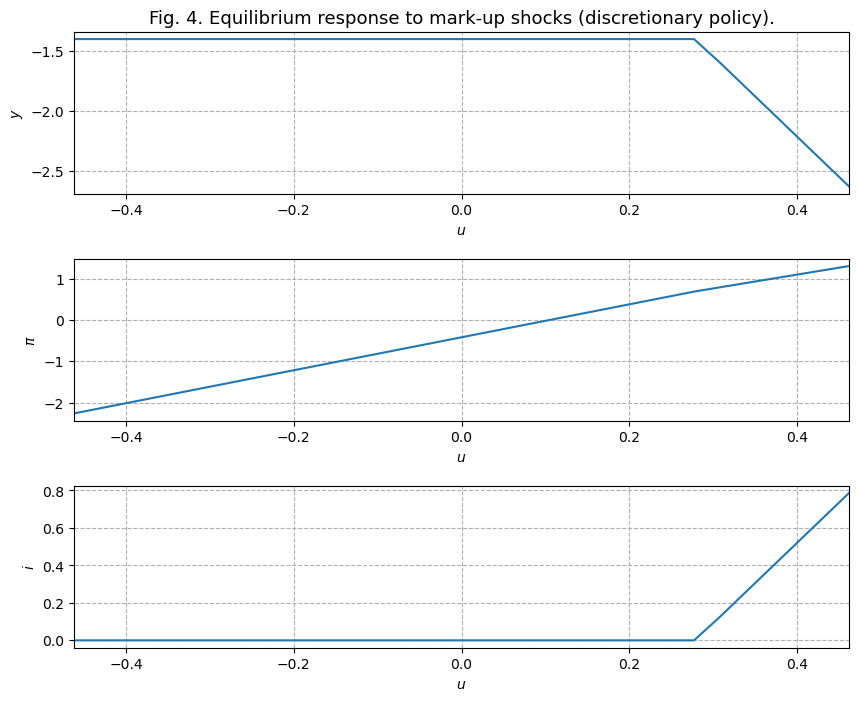

In [11]:

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,8))
fig.subplots_adjust(hspace=0.4)

ax[0].set_title("Fig. 4. Equilibrium response to mark-up shocks (discretionary policy).", fontsize=13)
ax[0].plot(u_grid, y_mat[g_zero_idx, :])
ax[0].set(xlabel=r"$u$", ylabel=r"$y$", xlim=(u_grid[0], u_grid[-1]))
ax[0].grid(ls="--")

ax[1].plot(u_grid, 4 * p_mat[g_zero_idx, :])
ax[1].set(xlabel=r"$u$", ylabel=r"$\pi$", xlim=(u_grid[0], u_grid[-1]))
ax[1].grid(ls="--")

ax[2].plot(u_grid, 4 * r_mat[g_zero_idx, :])
ax[2].set(xlabel=r"$u$", ylabel=r"$i$", xlim=(u_grid[0], u_grid[-1]))
ax[2].grid(ls="--")

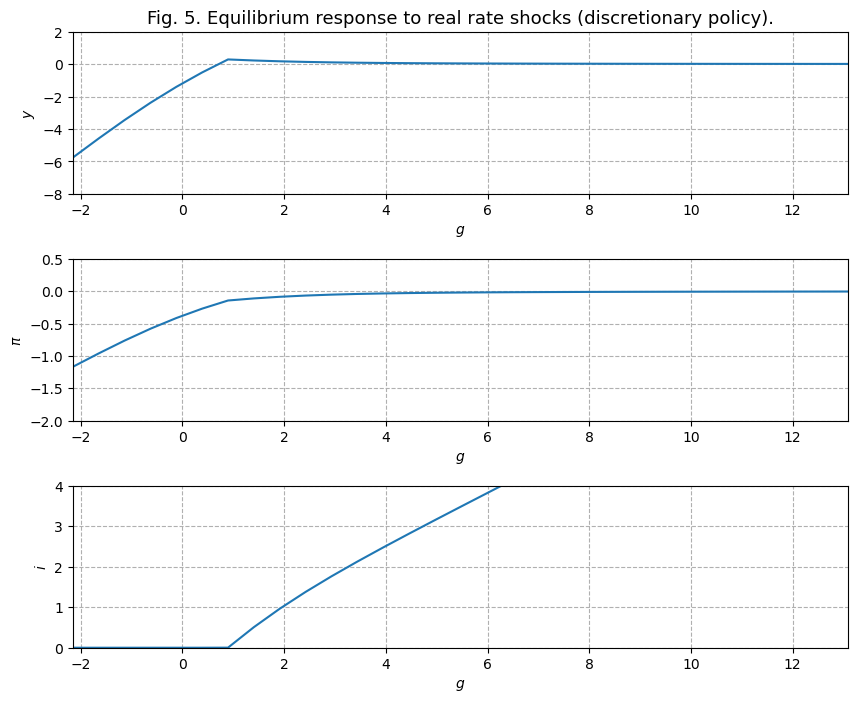

In [12]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
fig.subplots_adjust(hspace=0.4)

ax[0].set_title("Fig. 5. Equilibrium response to real rate shocks (discretionary policy).", fontsize=13)
ax[0].plot(g_grid, y_mat[:, u_zero_idx])
ax[0].set(xlabel=r"$g$", ylabel=r"$y$", xlim=(g_grid[0], g_grid[-1]), ylim=(-8,2))
ax[0].grid(ls="--")

ax[1].plot(g_grid, 4 * p_mat[:, u_zero_idx])
ax[1].set(xlabel=r"$g$", ylabel=r"$\pi$", xlim=(g_grid[0], g_grid[-1]), ylim=(-2,0.5))
ax[1].grid(ls="--")

ax[2].plot(g_grid, 4 * r_mat[:, u_zero_idx])
ax[2].set(xlabel=r"$g$", ylabel=r"$i$", xlim=(g_grid[0], g_grid[-1]), ylim=(0,4))
ax[2].grid(ls="--")

The following is given by the author:

In [13]:
# プロットを行うための準備
idu = int(Decimal(model.N_u/2).quantize(Decimal("0"), rounding = ROUND_CEILING)) # gについてのプロットを行う場合uはiduのインデックスで固定する
edg = int(Decimal(model.N_g/2).quantize(Decimal("0"), rounding = ROUND_CEILING)) # uについてのプロットを行う場合gはidgのインデックスで固定する
idu, edg

(16, 16)

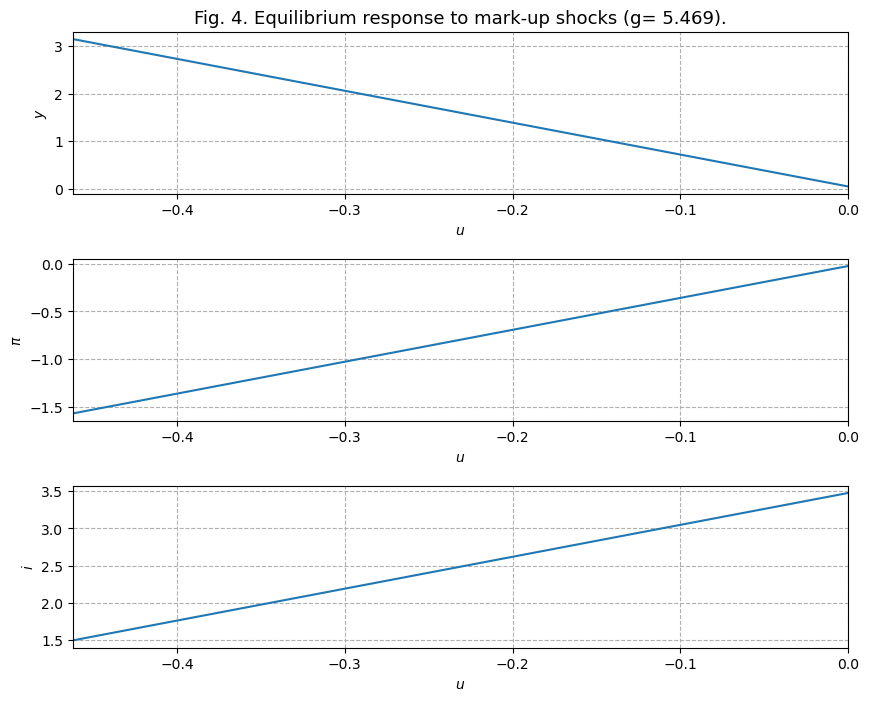

In [14]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
fig.subplots_adjust(hspace=0.4)

ax[0].set_title(f"Fig. 4. Equilibrium response to mark-up shocks (g={g_grid[edg-1]: .3f}).", fontsize=13)
ax[0].plot(u_grid[0:idu], y_mat[edg-1, 0:idu])
ax[0].set(xlabel=r"$u$", ylabel=r"$y$", xlim=(u_grid[0], u_grid[idu-1]))
ax[0].grid(ls="--")

ax[1].plot(u_grid[0:idu], 4 * p_mat[edg-1, 0:idu])
ax[1].set(xlabel=r"$u$", ylabel=r"$\pi$",xlim=(u_grid[0], u_grid[idu-1]))
ax[1].grid(ls="--")

ax[2].plot(u_grid[0:idu], 4 * r_mat[edg-1, 0:idu])
ax[2].set(xlabel=r"$u$", ylabel=r"$i$", xlim=(u_grid[0], u_grid[idu-1]))
ax[2].grid(ls="--")

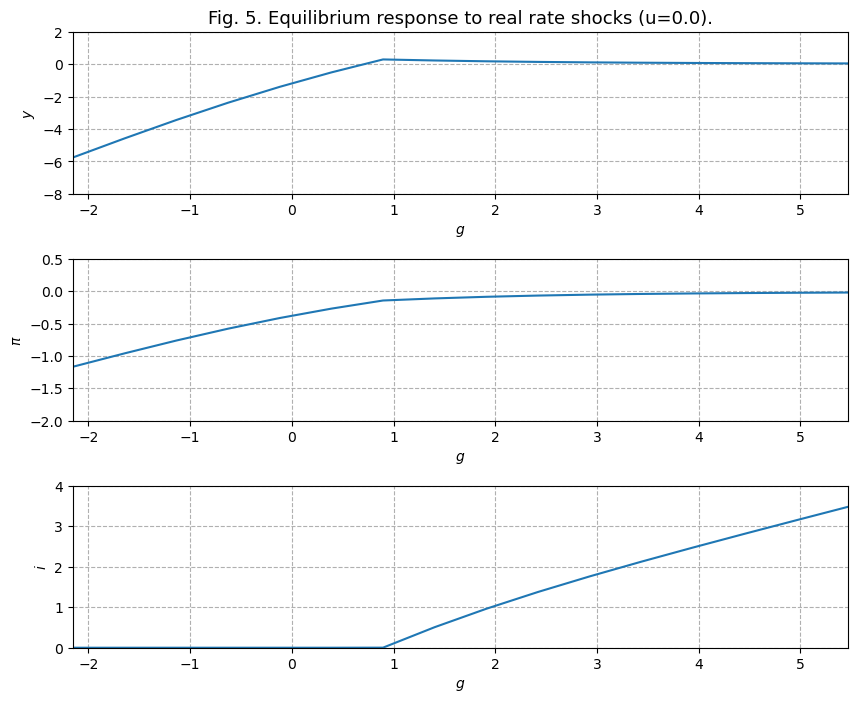

In [15]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
fig.subplots_adjust(hspace=0.4)

ax[0].set_title(f"Fig. 5. Equilibrium response to real rate shocks (u={u_grid[idu-1]}).", fontsize=13)
ax[0].plot(g_grid[0:edg], y_mat[0:edg, idu-1])
ax[0].set(xlabel=r"$g$", ylabel=r"$y$", xlim=(g_grid[0], g_grid[edg-1]), ylim=(-8,2))
ax[0].grid(ls="--")

ax[1].plot(g_grid[0:edg], 4 * p_mat[0:edg, idu-1])
ax[1].set(xlabel=r"$g$", ylabel=r"$\pi$",xlim=(g_grid[0], g_grid[edg-1]), ylim=(-2,0.5))
ax[1].grid(ls="--")

ax[2].plot(g_grid[0:edg], 4 * r_mat[0:edg, idu-1])
ax[2].set(xlabel=r"$g$", ylabel=r"$i$",xlim=(g_grid[0], g_grid[edg-1]), ylim=(0,4))
ax[2].grid(ls="--")